In [1]:
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============ Setup logging ============
log_dir = Path("./logs")
log_dir.mkdir(exist_ok=True)
log_file = log_dir / "processing.log"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)s] %(levelname)s: %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(),
    ]
)
logger = logging.getLogger(__name__)


# ============ Constants ============
START_DATE = pd.to_datetime("2021-01-01")
# FIX: Hardcoded Census Date for reproducibility (matches your proposal end date)
CENSUS_DATE = pd.to_datetime("2025-09-30") 


# Formating company data for regression

**Company DF**

- rcid               → firm_id
- user_id            → worker_id
- onet_code          → SOC occupation
- seniority          → seniority group
- startdate/enddate  → spells
- weight             → Revelio weight

**Needed table**

Job → DWA probability



## Merging with task -> Job

### Non vectorized

In [2]:
# ============ Load processed/failed tracking ============
processed_file = Path("./logs/processed.txt")
failed_file = Path("./logs/failed.txt")

processed = set()
failed = set()

if processed_file.exists():
    with open(processed_file) as f:
        processed = set(line.strip() for line in f if line.strip())

if failed_file.exists():
    with open(failed_file) as f:
        failed = set(line.strip() for line in f if line.strip())

logger.info(f"Current Status: {len(processed)} already processed, {len(failed)} known failures")


2025-12-02 17:06:03,491 [MainThread] INFO: Current Status: 4092 already processed, 0 known failures


In [4]:
# ============ Process function ============

def expand_months(row):
    # FIX: Snap start date to the 1st of the month
    # Without this, an employee starting Jan 15th would result in an empty range
    # because 'MS' (Month Start) would look for the next 1st (Feb 1st).
    start_snapped = row["startdate"].replace(day=1)
    
    months = pd.date_range(start_snapped, row["enddate"], freq="MS")
    
    return pd.DataFrame({
        "firm_id":   int(row["rcid"]),
        "onet_code": row["onet_code"],
        "seniority": int(row["seniority"]),
        "user_id":   int(row["user_id"]),
        "weight":    float(row["weight"]),
        "month":     months,
    })

def process_company_data(file_path, task_matrix):
    file_stem = file_path.stem
    try:
        df = pd.read_parquet(file_path, engine='pyarrow')
        
        # 1. Date Cleaning
        df['startdate'] = pd.to_datetime(df['startdate'])
        # FIX: Use CENSUS_DATE instead of now()
        df['enddate'] = pd.to_datetime(df['enddate']).fillna(CENSUS_DATE)
        
        # 2. Filter Valid Window
        # Keep anyone who worked AT ALL during the window
        df = df[df['enddate'] >= START_DATE].copy()
        
        # Clip start dates to window start so we don't expand months prior to 2021
        df.loc[df['startdate'] < START_DATE, 'startdate'] = START_DATE
        
        # 3. Expand to monthly panel (Non-Vectorized Loop)
        # Note: This is slower than vectorization but logically easier to read
        expanded_list = df.apply(expand_months, axis=1).tolist()
        
        if not expanded_list:
             # Handle case where file might be empty after filtering
             logger.warning(f"File {file_stem} resulted in empty dataframe after filtering")
             return (file_stem, "success") # Mark as success to avoid infinite retries
             
        expanded = pd.concat(expanded_list, ignore_index=True)

        # 4. Pre-Aggregation (Memory Fix)
        # Sum weights by Occupation first.
        expanded = expanded.groupby(
            ['firm_id', 'onet_code', 'month', 'seniority'], 
            as_index=False
        )['weight'].sum()

        expanded.rename(columns={'weight': 'headcount'}, inplace=True)

        # 5. Merge Tasks and Calculate FTE
        expanded = expanded.merge(task_matrix, left_on='onet_code', right_on='job_profile_id')
        expanded["FTE"] = expanded["FTE"] * expanded["headcount"]
        
        # 6. Final Aggregation
        panel = expanded.groupby(
            ['firm_id', 'dwa_id', 'month', 'seniority'],
            as_index=False
        )['FTE'].sum()
        
        output_dir = Path("./data/company_data_processed")
        output_dir.mkdir(parents=True, exist_ok=True)
        output_file = output_dir / f"processed_{file_stem}.parquet"
        panel.to_parquet(output_file, index=False, compression='snappy')
        
        logger.info(f"Successfully processed {file_stem}")
        return (file_stem, "success")
    
    except Exception as e:
        logger.error(f"Failed to process {file_stem}: {str(e)}", exc_info=True)
        return (file_stem, "failed")

# ============ Main processing loop ============
task_matrix = pd.read_csv('./data/job_DWA_FTE_distribution_30_0.csv')
task_matrix = task_matrix.dropna()
task_matrix = task_matrix[["job_profile_id", "dwa_id", "FTE"]]

data_dir = Path("./data/company_data")
parquet_files = list(data_dir.glob("*.parquet"))

# Filter to only unprocessed files
files_to_process = [
    f for f in parquet_files 
    if f.stem not in processed and f.stem not in failed
]

logger.info(f"Processing {len(files_to_process)} files (skipped {len(processed) + len(failed)} already done)")

# Process in parallel
futures_map = {}
with ThreadPoolExecutor(max_workers=5) as executor:
    for file_path in files_to_process:
        future = executor.submit(process_company_data, file_path, task_matrix)
        futures_map[future] = file_path.stem

    # Collect results
    for future in as_completed(futures_map):
        file_stem, status = future.result()
        
        if status == "success":
            processed.add(file_stem)
            with open(processed_file, "a") as f:
                f.write(f"{file_stem}\n")
        else:
            failed.add(file_stem)
            with open(failed_file, "a") as f:
                f.write(f"{file_stem}\n")

logger.info(f"Run complete: {len(processed)} successful, {len(failed)} failed")

2025-12-02 14:28:17,622 [MainThread] INFO: Processing 3519 files (skipped 573 already done)
2025-12-02 14:28:35,655 [ThreadPoolExecutor-0_3] INFO: Successfully processed 1265001
2025-12-02 14:28:35,675 [ThreadPoolExecutor-0_2] INFO: Successfully processed 1146667
2025-12-02 14:28:41,447 [ThreadPoolExecutor-0_4] INFO: Successfully processed 956768
2025-12-02 14:28:44,730 [ThreadPoolExecutor-0_1] INFO: Successfully processed 1167052
2025-12-02 14:28:49,602 [ThreadPoolExecutor-0_3] INFO: Successfully processed 78416
2025-12-02 14:28:50,113 [ThreadPoolExecutor-0_2] INFO: Successfully processed 22238486
2025-12-02 14:28:58,994 [ThreadPoolExecutor-0_4] INFO: Successfully processed 263644
2025-12-02 14:28:59,081 [ThreadPoolExecutor-0_3] INFO: Successfully processed 66196
2025-12-02 14:28:59,194 [ThreadPoolExecutor-0_0] INFO: Successfully processed 513460
2025-12-02 14:29:00,419 [ThreadPoolExecutor-0_3] INFO: Successfully processed 1501743
2025-12-02 14:29:00,422 [ThreadPoolExecutor-0_1] INFO:

# Merging on one seniority level

In [74]:
data_dir = Path("./data/company_data_processed")
parquet_files_processed = list(data_dir.glob("*.parquet"))

In [75]:
SENIORITY = [3]

# Use list + pd.concat instead of deprecated DataFrame.append
frames = []
for file_path in parquet_files_processed:
    tmp = pd.read_parquet(file_path)
    tmp = tmp[tmp["seniority"].isin(SENIORITY)]
    if not tmp.empty:
        frames.append(tmp)

if frames:
    full_df = pd.concat(frames, ignore_index=True)
else:
    full_df = pd.DataFrame(columns=["firm_id", "dwa_id", "month", "seniority", "FTE"])

full_df.reset_index(drop=True, inplace=True)
full_df = full_df.dropna()

In [76]:
import pandas as pd

# ---------------------------------------------------------
# 1. SETUP & PARAMETERS
# ---------------------------------------------------------
# Assuming 'full_df' is your loaded dataframe
# full_df['month'] = pd.to_datetime(full_df['month']) # Ensure datetime

# Filter Parameters from the proposal
PRE_START = '2021-01-01'
PRE_END = '2022-10-01'
TAU_FIRMS = 100          # Minimum distinct firms
TAU_MASS_PCT = 0.001    # Minimum % of global labor mass

print(f"Initial Dataset Size: {len(full_df):,} rows")
print(f"Initial Unique Tasks: {full_df['dwa_id'].nunique():,}")

# ---------------------------------------------------------
# 2. IDENTIFY VALID TASKS (Based on Pre-Treatment Data)
# ---------------------------------------------------------
# Isolate the pre-treatment window for calculation
pre_df = full_df[
    (full_df['month'] >= PRE_START) & 
    (full_df['month'] <= PRE_END)
].copy()

# Calculate global mass (denominator)
total_global_fte = pre_df['FTE'].sum()

# Aggregate stats per task
task_stats = pre_df.groupby('dwa_id').agg(
    distinct_firms=('firm_id', 'nunique'),
    total_task_fte=('FTE', 'sum')
)

# Calculate mass share percentage
task_stats['mass_share_pct'] = (task_stats['total_task_fte'] / total_global_fte) * 100

# Create the Boolean Mask for valid tasks
valid_mask = (
    (task_stats['distinct_firms'] >= TAU_FIRMS) & 
    (task_stats['mass_share_pct'] >= TAU_MASS_PCT)
)

# Extract the list of valid IDs
valid_dwa_ids = task_stats[valid_mask].index.tolist()

print("-" * 40)
print(f"Tasks meeting criteria: {len(valid_dwa_ids):,}")
print(f"Tasks discarded: {len(task_stats) - len(valid_dwa_ids):,}")

# ---------------------------------------------------------
# 3. APPLY FILTER TO MAIN DATASET
# ---------------------------------------------------------
# We filter the ORIGINAL full_df to keep only the valid tasks.
# This drops rows for niche tasks across ALL time periods.

filtered_df = full_df[full_df['dwa_id'].isin(valid_dwa_ids)].copy()

print("-" * 40)
print(f"Final Dataset Size: {len(filtered_df):,} rows")
print(f"Final Unique Tasks: {filtered_df['dwa_id'].nunique():,}")

# Optional: Garbage collection to free up memory if full_df was huge
# import gc
# del full_df
# gc.collect()

Initial Dataset Size: 71,430,730 rows
Initial Unique Tasks: 1,955
----------------------------------------
Tasks meeting criteria: 1,443
Tasks discarded: 512
----------------------------------------
Final Dataset Size: 69,730,628 rows
Final Unique Tasks: 1,443


In [77]:
import pandas as pd
import numpy as np

def balance_panel(df):
    print("--- Starting Panel Balancing ---")
    
    # 1. Ensure Date Format
    df = df.copy()
    df['month'] = pd.to_datetime(df['month'])
    
    # 2. Define the Full Time Range (Jan 2021 to Sep 2025)
    # This creates a list of 57 months
    all_months = pd.date_range(start='2021-01-01', end='2025-09-01', freq='MS')
    
    # 3. Identify Unique Entity Pairs (Firm + DWA + Seniority)
    # We include seniority so the new '0' rows inherit the correct seniority label
    unique_keys = df[['firm_id', 'dwa_id', 'seniority']].drop_duplicates()
    
    print(f"Unique Firm-Task pairs to balance: {len(unique_keys):,}")
    
    # 4. Create the 'Skeleton' (The Target Grid)
    # We use a cross-join to repeat every unique pair for every month
    # This results in: (Num_Pairs * 57) rows
    
    # Create a temporary key for the cross join
    unique_keys['_temp_key'] = 1
    months_df = pd.DataFrame({'month': all_months, '_temp_key': 1})
    
    # Cross join: This creates the perfect empty grid
    skeleton = pd.merge(unique_keys, months_df, on='_temp_key').drop('_temp_key', axis=1)
    
    print(f"Target balanced size: {len(skeleton):,} rows")
    
    # 5. Merge the Original Data onto the Skeleton
    # Use LEFT JOIN: Keep the skeleton, fill data where it exists
    balanced_df = pd.merge(
        skeleton, 
        df, 
        on=['firm_id', 'dwa_id', 'seniority', 'month'], 
        how='left'
    )
    
    # 6. Fill Missing FTEs with 0
    # Any row that existed in skeleton but not in df is now NaN. We make it 0.
    balanced_df['FTE'] = balanced_df['FTE'].fillna(0)
    
    # 7. Recalculate 'time_j' (required for the regression later)
    # Reference Date: Oct 2022
    ref_dt = pd.to_datetime('2022-10-01')
    balanced_df['time_j'] = (balanced_df['month'].dt.year - ref_dt.year) * 12 + \
                            (balanced_df['month'].dt.month - ref_dt.month)
    
    print("--- Balancing Complete ---")
    return balanced_df

# ==========================================
# EXECUTE THE CODE
# ==========================================

# Apply the balancing
balanced_df = balance_panel(filtered_df)

print("-" * 40)
print(f"Final Dataset Size: {len(balanced_df):,} rows")
print(f"Final Unique Companies: {balanced_df['firm_id'].nunique():,}")
print(f"Final Unique Tasks: {balanced_df['dwa_id'].nunique():,}")

--- Starting Panel Balancing ---
Unique Firm-Task pairs to balance: 1,571,306
Target balanced size: 89,564,442 rows
--- Balancing Complete ---
----------------------------------------
Final Dataset Size: 89,564,442 rows
Final Unique Companies: 3,841
Final Unique Tasks: 1,443


--- Analyzing Task Complexity ---

--- Task Distribution Summary ---
category
Large (Dual Core)        225
Medium (Low Parallel)    542
Small (High Parallel)    521
Whale (Sequential)       155
Name: count, dtype: int64

Max Firms in a single task: 3505
Min Firms in a single task: 127


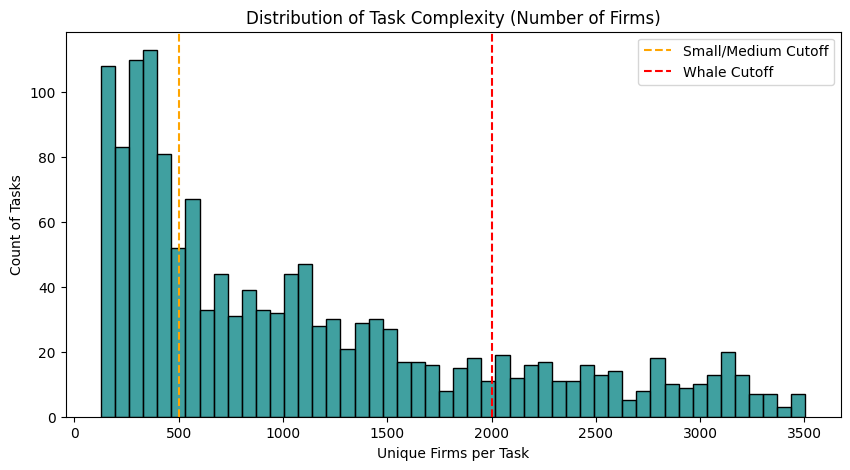


Recommended Strategy:
1. Run 521 Small tasks on 8 cores.
2. Run 542 Medium tasks on 4 cores.
3. Run 225 Large tasks on 2 cores.
4. Run 155 Whale tasks sequentially (1 core).


In [78]:
def analyze_and_segment_tasks(df, plot=True):
    print("--- Analyzing Task Complexity ---")
    
    # 1. Calculate Complexity Metrics per Task
    # We care most about 'nunique firms' because that determines the matrix width
    task_stats = df.groupby('dwa_id').agg(
        n_firms=('firm_id', 'nunique'),
        n_obs=('FTE', 'count')
    ).reset_index()
    
    # 2. Define Complexity Categories
    # Thresholds based on M1 Max 64GB constraints:
    # Small: < 500 firms (Safe for 8 cores)
    # Medium: 500 - 1500 firms (Safe for 4 cores)
    # Large: 1,500 - 2,500 firms (Safe for 2 cores)
    # Whale: > 2,500 firms (Must run sequential / 1 core)
    
    def classify(n):
        if n < 500: return 'Small (High Parallel)'
        elif n < 1500: return 'Medium (Low Parallel)'
        elif n < 2500: return 'Large (Dual Core)'
        else: return 'Whale (Sequential)'

    task_stats['category'] = task_stats['n_firms'].apply(classify)
    
    # 3. Print Summary
    print("\n--- Task Distribution Summary ---")
    summary = task_stats['category'].value_counts().sort_index()
    print(summary)
    
    print(f"\nMax Firms in a single task: {task_stats['n_firms'].max()}")
    print(f"Min Firms in a single task: {task_stats['n_firms'].min()}")
    
    # 4. (Optional) Visualization
    if plot:
        plt.figure(figsize=(10, 5))
        sns.histplot(task_stats['n_firms'], bins=50, kde=False, color='teal')
        plt.axvline(500, color='orange', linestyle='--', label='Small/Medium Cutoff')
        plt.axvline(2000, color='red', linestyle='--', label='Whale Cutoff')
        plt.title("Distribution of Task Complexity (Number of Firms)")
        plt.xlabel("Unique Firms per Task")
        plt.ylabel("Count of Tasks")
        plt.legend()
        plt.show()

    # 5. Return Split Lists
    batches = {
        'small': task_stats[task_stats['n_firms'] < 500]['dwa_id'].tolist(),
        'medium': task_stats[(task_stats['n_firms'] >= 500) & (task_stats['n_firms'] < 1500)]['dwa_id'].tolist(),
        'large': task_stats[(task_stats['n_firms'] >= 1500) & (task_stats['n_firms'] < 2500)]['dwa_id'].tolist(),
        'whale': task_stats[task_stats['n_firms'] >= 2500]['dwa_id'].tolist()
    }
    
    return task_stats, batches

# ==========================================
# EXECUTE
# ==========================================
task_stats_df, batches = analyze_and_segment_tasks(balanced_df)

print(f"\nRecommended Strategy:")
print(f"1. Run {len(batches['small'])} Small tasks on 8 cores.")
print(f"2. Run {len(batches['medium'])} Medium tasks on 4 cores.")
print(f"3. Run {len(batches['large'])} Large tasks on 2 cores.")
print(f"4. Run {len(batches['whale'])} Whale tasks sequentially (1 core).")

## Full

In [1]:
import pandas as pd
import numpy as np
from pyfixest.estimation import fepois
import os
import gc
import psutil
import time

# ---------------------------------------------------------
# HELPER: MEMORY MONITORING
# ---------------------------------------------------------
def print_memory(step_name=""):
    process = psutil.Process(os.getpid())
    mem_gb = process.memory_info().rss / 1024 ** 3
    print(f" 💾 RAM [{step_name}]: {mem_gb:.2f} GB")
    return mem_gb

# ---------------------------------------------------------
# 1. OPTIMIZER FUNCTION
# ---------------------------------------------------------
def optimize_dataframe(df):
    """
    Aggressively downcasts data types to fit in RAM.
    """
    print(" ...Optimizing data types...")
    
    # 1. Calculate Time Index (int16 is safe for +/- 32,000 months)
    # We do this before downcasting to avoid overflow during calculation
    if 'time_j' not in df.columns:
        REF_DATE = pd.to_datetime('2022-10-01')
        df['month'] = pd.to_datetime(df['month'])
        df['time_j'] = (df['month'].dt.year - REF_DATE.year) * 12 + \
                       (df['month'].dt.month - REF_DATE.month)
    
    # 2. Downcast Numerics
    df['time_j'] = df['time_j'].astype('int16')  # 2 bytes
    df['FTE'] = df['FTE'].astype('float32')      # 4 bytes (Standard single precision)

    # 3. Categoricals (Crucial for Fixed Effects)
    # This stores the string "Google" as an integer (e.g., 1) internally
    df['firm_id'] = df['firm_id'].astype('category')
    df['dwa_id'] = df['dwa_id'].astype('category')
    
    # 4. Drop Unused Columns
    cols_to_keep = ['FTE', 'time_j', 'firm_id', 'dwa_id']
    
    # Keep quintile if it exists (for fallback)
    if 'exposure_quintile' in df.columns:
        df['exposure_quintile'] = df['exposure_quintile'].astype('category')
        cols_to_keep.append('exposure_quintile')

    df = df[cols_to_keep]
    
    gc.collect()
    return df

# ---------------------------------------------------------
# 2. SAFETY CHECK (5% SAMPLE)
# ---------------------------------------------------------
def run_safety_check(df_full):
    print("\n⚠️  INITIATING 5% SAFETY CHECK ⚠️")
    print_memory("Start Safety")
    
    # Sample 5% of FIRMS (to keep panel structure intact)
    unique_firms = df_full['firm_id'].unique()
    safe_firms = np.random.choice(unique_firms, size=int(len(unique_firms) * 0.05), replace=False)
    
    # Create safe subset
    safe_df = df_full[df_full['firm_id'].isin(safe_firms)].copy()
    print(f" > Testing on {len(safe_firms)} firms ({len(safe_df)} rows)...")
    
    try:
        mem_start = print_memory("Before Model")
        
        # Run the EXACT model you intend to run full scale
        # Using dwa_id interaction (Granular Spec)
        fml = "FTE ~ i(time_j, dwa_id, ref=0) | firm_id^time_j"
        
        model = fepois(
            fml=fml,
            data=safe_df,
            vcov={'CRV1': 'firm_id'},
            ssc={'adj': False} # Disable small sample correction for speed
        )
        
        mem_end = print_memory("After Model")
        spike = mem_end - mem_start
        
        print(f" > RAM Spike for 5% Data: {spike:.2f} GB")
        
        # Heuristic: Linear scaling isn't perfect, but it's a good warning
        # If 5% took 3GB, 100% might need 60GB (Danger Zone)
        if spike > 2.5:
            print(f"🚨 DANGER: Projected RAM usage > 50GB. The full run might crash.")
            print("   RECOMMENDATION: Switch to Quintile Aggregation (Spec 1).")
            return False
        else:
            print("✅ SAFE: RAM usage is within safe limits.")
            return True
            
    except Exception as e:
        print(f"❌ Safety Check Failed: {e}")
        return False
    finally:
        del safe_df
        del model
        gc.collect()

# ---------------------------------------------------------
# 3. MAIN ESTIMATION RUNNER
# ---------------------------------------------------------
def run_full_estimation(df):
    print("\n🚀 STARTING FULL ESTIMATION")
    print_memory("Start Full")
    
    start_time = time.time()
    
    # SPECIFICATION: Granular Task Level
    # Fixed Effects: Firm-by-Time (absorbs recession)
    # Variables: Interaction of Time * TaskID
    fml = "FTE ~ i(time_j, dwa_id, ref=0) | firm_id^time_j"
    
    print(f" > Formula: {fml}")
    print(" > Solver: Poisson Pseudo-Maximum Likelihood (Newton-Raphson)")
    
    try:
        model = fepois(
            fml=fml, 
            data=df, 
            vcov={'CRV1': 'firm_id'}, 
            ssc={'adj': False}
        )
        
        elapsed = (time.time() - start_time) / 60
        print(f"✅ Estimation Finished in {elapsed:.1f} minutes.")
        
        # Extract Results safely
        print(" > Extracting coefficients...")
        results = model.tidy()
        
        # Filter only the interaction terms we care about
        # (The model object is huge, we want to dump it ASAP)
        results = results[results.index.astype(str).str.contains('time_j')]
        
        return results

    except Exception as e:
        print(f"❌ CRITICAL ERROR: {e}")
        return None

# ---------------------------------------------------------
# EXECUTION FLOW
# ---------------------------------------------------------
if __name__ == "__main__":
    
    # 1. LOAD & OPTIMIZE
    # Assuming 'balanced_df' is your raw dataframe loaded from parquet/joblib
    # balanced_df = pd.read_parquet("your_data.parquet") 
    
    # OPTIMIZE IN PLACE (Overwrite variable to free old memory)
    balanced_df = pd.read_parquet('./data/balanced_full_df.parquet')
    balanced_df = optimize_dataframe(balanced_df)
    
    # 2. SAFETY FIRST
    is_safe = run_safety_check(balanced_df)
    
    # 3. CONDITIONAL EXECUTION
    if is_safe:
        # Proceed with Granular Task Model
        results = run_full_estimation(balanced_df)
        
        if results is not None:
            print("\nPreview of Results:")
            print(results.head())
            # results.to_csv("final_task_coefficients.csv")
    else:
        print("\n⚠️ ABORTING GRANULAR RUN TO PROTECT HARDWARE.")
        print("   Please restart using Quintile Aggregation method.")

 ...Optimizing data types...

⚠️  INITIATING 5% SAFETY CHECK ⚠️
 💾 RAM [Start Safety]: 7.55 GB
 > Testing on 192 firms (4323735 rows)...
 💾 RAM [Before Model]: 7.67 GB


: 

## Sequential

In [79]:
import pandas as pd
import numpy as np
from pyfixest.estimation import fepois
from joblib import dump, load
import os
import shutil
import tempfile
from tqdm import tqdm
import gc
import re

# ---------------------------------------------------------
# 1. TASK PROCESSOR (Sequential Version)
# ---------------------------------------------------------
def process_task_sequential(folder_path, task_id, ref_time_j, ref_date_ts):
    # Aggressive Cleanup between tasks
    gc.collect()
    
    try:
        # Load Data (Zero Copy)
        full_df = load(os.path.join(folder_path, 'full_df.joblib'), mmap_mode='r')
        task_df = full_df[full_df['dwa_id'] == task_id].copy()
        
        if len(task_df) < 50:
            return None
            
        # Run Model
        fml = f"FTE ~ i(time_j, ref={ref_time_j}) | firm_id"
        model = fepois(fml=fml, data=task_df, vcov={'CRV1': 'firm_id'})
        
        # Extract Results
        results_table = model.tidy()
        
        rows = []
        # Add Reference Period (t=0)
        rows.append({
            'dwa_id': task_id,
            'time_j': 0,
            'beta': 0.0,
            'se': 0.0
        })
        
        # Parse Coefficients
        for term_name, row in results_table.iterrows():
            term_str = str(term_name)
            # Regex for integer time index
            match = re.search(r'time_j::(-?\d+)|\[T\.(-?\d+)\]', term_str)
            
            if match:
                t_val_str = match.group(1) if match.group(1) else match.group(2)
                t_val = int(t_val_str)
                
                rows.append({
                    'dwa_id': task_id,
                    'time_j': t_val,
                    'beta': row['Estimate'],
                    'se': row['Std. Error']
                })
        
        # Format output
        task_results = pd.DataFrame(rows)
        ref_dt = pd.Timestamp(ref_date_ts)
        task_results['date'] = task_results['time_j'].apply(
            lambda x: ref_dt + pd.DateOffset(months=x)
        )
        
        # Explicit cleanup of heavy objects
        del model
        del task_df
        del full_df
        
        return task_results[['date', 'dwa_id', 'beta', 'se']]

    except Exception as e:
        # print(f"Error on {task_id}: {e}")
        return None

# ---------------------------------------------------------
# 2. MAIN RUNNER
# ---------------------------------------------------------
def run_experiment_sequential(balanced_df):
    print("--- STARTING SEQUENTIAL EXPERIMENT (MAX STABILITY) ---")
    
    temp_folder = tempfile.mkdtemp()
    print(f" > Temp storage: {temp_folder}")
    
    try:
        # Setup
        print(" > Preparing data...")
        full_df = balanced_df.copy()
        full_df['month'] = pd.to_datetime(full_df['month'])
        
        REF_DATE = '2022-10-01'
        ref_dt = pd.to_datetime(REF_DATE)
        
        full_df['time_j'] = (full_df['month'].dt.year - ref_dt.year) * 12 + \
                            (full_df['month'].dt.month - ref_dt.month)
        full_df['time_j'] = full_df['time_j'].astype(int)
        
        ref_time_j = 0
        ref_date_ts = ref_dt.value 
        
        print(" > Dumping to SSD...")
        dump(full_df, os.path.join(temp_folder, 'full_df.joblib'))
        
        # Sort tasks by size (Process smallest first to build momentum)
        # Or Random to average out the ETA
        unique_tasks = full_df['dwa_id'].unique()
        print(f" > Processing {len(unique_tasks)} tasks sequentially...")
        
        results_list = []
        
        # SEQUENTIAL LOOP
        for task in tqdm(unique_tasks, desc="Regressing"):
            res = process_task_sequential(temp_folder, task, ref_time_j, ref_date_ts)
            if res is not None:
                results_list.append(res)
        
        # Aggregate
        if not results_list:
            print("❌ No results.")
            return None
            
        print(" > Aggregating...")
        master_df = pd.concat(results_list, ignore_index=True)
        master_df = master_df.sort_values(['dwa_id', 'date'])
        master_df.set_index(['dwa_id', 'date'], inplace=True)
        
        print(f"✅ Success! Completed {len(results_list)} tasks.")
        return master_df

    finally:
        try:
            shutil.rmtree(temp_folder)
            print(" > Cleanup complete.")
        except:
            pass

# Run it
final_results_df = run_experiment_sequential(balanced_df)

--- STARTING SEQUENTIAL EXPERIMENT (MAX STABILITY) ---
 > Temp storage: /var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/tmp0pqpcs3b
 > Preparing data...
 > Dumping to SSD...
 > Processing 1443 tasks sequentially...


Regressing:  24%|██▍       | 351/1443 [1:02:12<3:13:32, 10.63s/it]

 > Cleanup complete.


KeyboardInterrupt: 

In [ ]:
final_results_df = final_results_df.reset_index()
final_results_df["seniority"] = SENIORITY
final_results_df.to_csv(f'./output/all_DWAs_{SENIORITY}.csv', index=False)

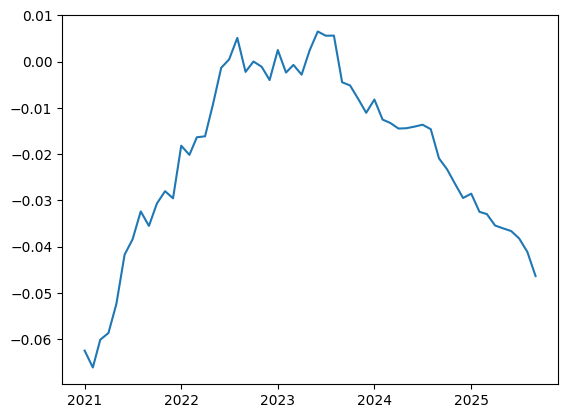

In [ ]:
effect_evolution = final_results_df.groupby('date').agg({'beta': 'mean', 'se': 'mean'})
plt.plot(effect_evolution["beta"], label='Average Beta')

In [ ]:
def calculate_realized_shocks(time_series_df):
    print("--- CALCULATING REALIZED SHOCKS (EQUATION 3) ---")
    
    # 1. Define the "Mature" Window
    # Proposal: "Average effect over the mature post-treatment period: Jan 24 to Sep 25"
    start_date = '2024-01-01'
    end_date = '2025-09-01'
    
    # 2. Filter Data
    # Ensure index is accessible as columns for filtering
    df = time_series_df.reset_index()
    
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    post_period_data = df[mask]
    
    print(f"Averaging coefficients from {start_date} to {end_date}...")
    
    # 3. Group and Average
    shocks = post_period_data.groupby('dwa_id').agg(
        realized_shock=('beta', 'mean'),
        avg_se=('se', 'mean'),  # Useful for weighting later
        n_months=('date', 'count') # Quality check (should be ~21)
    ).reset_index()
    
    print(f"✅ Computed shocks for {len(shocks)} tasks.")
    print(shocks.head())
    
    return shocks

# Run it
task_shocks_df = calculate_realized_shocks(final_results_df)

--- CALCULATING REALIZED SHOCKS (EQUATION 3) ---
Averaging coefficients from 2024-01-01 to 2025-09-01...
✅ Computed shocks for 1636 tasks.
              dwa_id  realized_shock    avg_se  n_months
0  4.A.1.a.1.I01.D01       -0.099011  0.038639        21
1  4.A.1.a.1.I01.D02       -0.044802  0.014228        21
2  4.A.1.a.1.I01.D04       -0.088594  0.017244        21
3  4.A.1.a.1.I02.D01       -0.004300  0.014432        21
4  4.A.1.a.1.I02.D02       -0.061639  0.020788        21


In [ ]:
task_shocks_df.sort_values('realized_shock', ascending=False)

,dwa_id,realized_shock,avg_se,n_months
281,4.A.1.b.3.I04.D03,0.266611,0.210583,21
36,4.A.1.a.1.I06.D03,0.266611,0.210583,21
458,4.A.2.b.2.I01.D01,0.259714,0.124409,21
88,4.A.1.a.2.I01.D02,0.256026,0.095231,21
514,4.A.2.b.2.I15.D10,0.250655,0.174304,21
...,...,...,...,...
1441,4.A.4.b.4.I07.D02,-0.246488,0.022686,21
290,4.A.2.a.1.I02.D04,-0.246497,0.022687,21
27,4.A.1.a.1.I04.D03,-0.293550,0.127829,21
352,4.A.2.a.3.I01.D08,-0.298188,0.119519,21


# Analysis

In [ ]:
exposure_df = pd.read_csv("./data/full_labelset.tsv", sep="\t")
exposure_df = exposure_df[["Task ID", "alpha", "beta", "gamma"]]

task_dwa_map = pd.read_csv('./data/Tasks to DWAs.csv')
task_dwa_map = task_dwa_map[["DWA ID", "Task ID"]]

DWA_exposure_df = pd.merge(exposure_df, task_dwa_map, on="Task ID", how ="inner")
DWA_exposure_df = DWA_exposure_df.groupby('DWA ID').agg(
    beta=('beta', 'mean'),
    alpha=('alpha', 'mean'),
    gamma=('gamma', 'mean')
).reset_index()

DWA_exposure_df = pd.merge(task_shocks_df, DWA_exposure_df, left_on='dwa_id', right_on='DWA ID', how='inner')
DWA_exposure_df

In [ ]:
# regression of the shock on alpha, beta, gamma
import statsmodels.api as sm
X = DWA_exposure_df[['beta', 'alpha', 'gamma']]
y = DWA_exposure_df['realized_shock']
X = sm.add_constant(X)  # Adds a constant term to the predictors
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         realized_shock   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     20.53
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.57e-09
Time:                        21:19:39   Log-Likelihood:                 2231.3
No. Observations:                1636   AIC:                            -4457.
Df Residuals:                    1633   BIC:                            -4440.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0124      0.003     -4.851      0.0

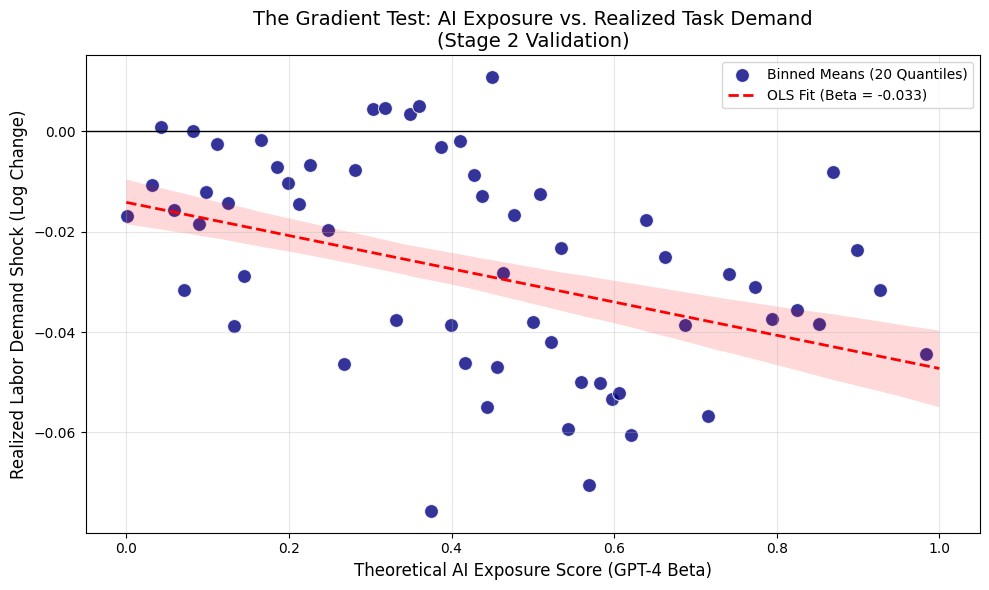

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_gradient_test(df):
    # Create a copy to avoid SettingWithCopy warnings
    plot_df = df.copy()
    
    # -------------------------------------------------------
    # 1. PREPARE BINS (VISUALIZATION ONLY)
    # -------------------------------------------------------
    # We group tasks into 20 equal-sized buckets based on exposure.
    # This filters out the task-specific noise so you can see the trend.
    plot_df['exposure_bin'] = pd.qcut(plot_df['beta'], q=100, labels=False, duplicates='drop')
    
    # Calculate average X and Y for each bin
    bin_stats = plot_df.groupby('exposure_bin').agg({
        'beta': 'mean',           # X-axis center of the bin
        'realized_shock': 'mean'  # Y-axis center of the bin
    }).reset_index()

    # -------------------------------------------------------
    # 2. PLOTTING
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))
    
    # A. Plot the Bins (The "Dots")
    sns.scatterplot(
        data=bin_stats,
        x='beta', 
        y='realized_shock',
        s=100,              # Size of dots
        color='navy',       # Dark blue
        alpha=0.8,
        label='Binned Means (20 Quantiles)'
    )
    
    # B. Plot the Regression Line (The "Fit")
    # We use the FULL dataset for the line, not the bins, to be accurate
    sns.regplot(
        data=plot_df,
        x='beta',
        y='realized_shock',
        scatter=False,      # Don't plot the 1600 messy dots again
        color='red',
        line_kws={'linestyle': '--', 'linewidth': 2},
        label='OLS Fit (Beta = -0.033)'
    )
    
    # -------------------------------------------------------
    # 3. STYLING
    # -------------------------------------------------------
    plt.axhline(0, color='black', linewidth=1) # Zero line
    
    plt.title("The Gradient Test: AI Exposure vs. Realized Task Demand\n(Stage 2 Validation)", fontsize=14)
    plt.xlabel("Theoretical AI Exposure Score (GPT-4 Beta)", fontsize=12)
    plt.ylabel("Realized Labor Demand Shock (Log Change)", fontsize=12)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

# Run it on your dataframe
plot_gradient_test(DWA_exposure_df)